In [1]:
# from anokas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

import cv2
import platform
from tqdm import tqdm
import h5py
import yaml

Using TensorFlow backend.


In [2]:
image_size = (150,150)

df_train = pd.read_csv('../data/train_v2.csv')

In [3]:
with open('../label_maps.yml', 'r') as lablels:
    label_data = yaml.load(lablels)
inv_label_map = label_data['inv_label_map']
label_map = label_data['label_map']

In [4]:
x_train = []
y_train = []


for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, image_size))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

100%|██████████| 40479/40479 [01:09<00:00, 578.40it/s]


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=42)
print(x_train.shape)
print(y_train.shape)

(34407, 150, 150, 3)
(34407, 17)


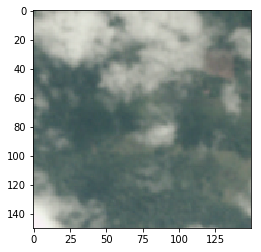

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
image_to_plot = (x_train[279]*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
import sys
sys.executable

'/usr/bin/python3'

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint


input_shape = (150,150,3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(17))
model.add(Activation('sigmoid'))

file_path = '../models/simple_cnn_weights_{epoch:02d}_{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', period=1)

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy']
             )

In [ ]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=40,
          verbose=1,
          validation_data=(x_valid, y_valid),
         callbacks = [model_checkpoint])

Train on 34407 samples, validate on 6072 samples
Epoch 1/40
34407/34407 [==============================] - 124s - loss: 0.2746 - acc: 0.8960 - val_loss: 0.1983 - val_acc: 0.9215
Epoch 2/40
34407/34407 [==============================] - 118s - loss: 0.2169 - acc: 0.9161 - val_loss: 0.1896 - val_acc: 0.9242
Epoch 3/40
34407/34407 [==============================] - 118s - loss: 0.2040 - acc: 0.9194 - val_loss: 0.1781 - val_acc: 0.9284
Epoch 4/40
34407/34407 [==============================] - 118s - loss: 0.1936 - acc: 0.9237 - val_loss: 0.1695 - val_acc: 0.9334
Epoch 5/40
34407/34407 [==============================] - 118s - loss: 0.1906 - acc: 0.9253 - val_loss: 0.1800 - val_acc: 0.9262
Epoch 6/40
34407/34407 [==============================] - 118s - loss: 0.1836 - acc: 0.9284 - val_loss: 0.1607 - val_acc: 0.9372
Epoch 7/40
34407/34407 [==============================] - 118s - loss: 0.1780 - acc: 0.9308 - val_loss: 0.1574 - val_acc: 0.9369
Epoch 8/40
34407/34407 [========================

In [ ]:
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_valid, batch_size=128)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))